In [28]:
import numpy as np
import scipy.sparse as sp
import sknetwork as sn
import numba
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import f1_score as F1
import matplotlib.pyplot as plt
import seaborn as sns

from abcd_graph import ABCDGraph, ABCDParams
from partition_sknetwork import ECG
from tqdm import tqdm
import CAS

In [2]:
@numba.njit
def get_cas(labels, adjacency_indptr, adjacency_indices, adjacency_data, cas):
    # Assume labels is a partition
    # return a numpy array with the cas score to each label
    scores = np.empty(len(labels))
    labels_indptr, labels_indices, labels_data = CAS.cas_._labels_array_to_matrix(labels)
    graph_volume = np.sum(adjacency_data)
    label_volumes = np.empty(np.max(labels)+1)
    for label in range(len(label_volumes)):
        nodes = labels_indices[labels_indptr[label] : labels_indptr[label + 1]]
        label_volume = CAS.cas_._get_volume(
            nodes,
            adjacency_indptr,
            adjacency_indices,
            adjacency_data)
        label_volumes[label] = label_volume / graph_volume

    for i in range(len(scores)):
        scores[i] = cas(
            i,
            labels[i],
            label_volumes[labels[i]],
            labels_indptr,
            labels_indices,
            adjacency_indptr,
            adjacency_indices,
            adjacency_data
        )

    return scores

            

100%|██████████| 250/250 [09:01<00:00,  2.17s/it]


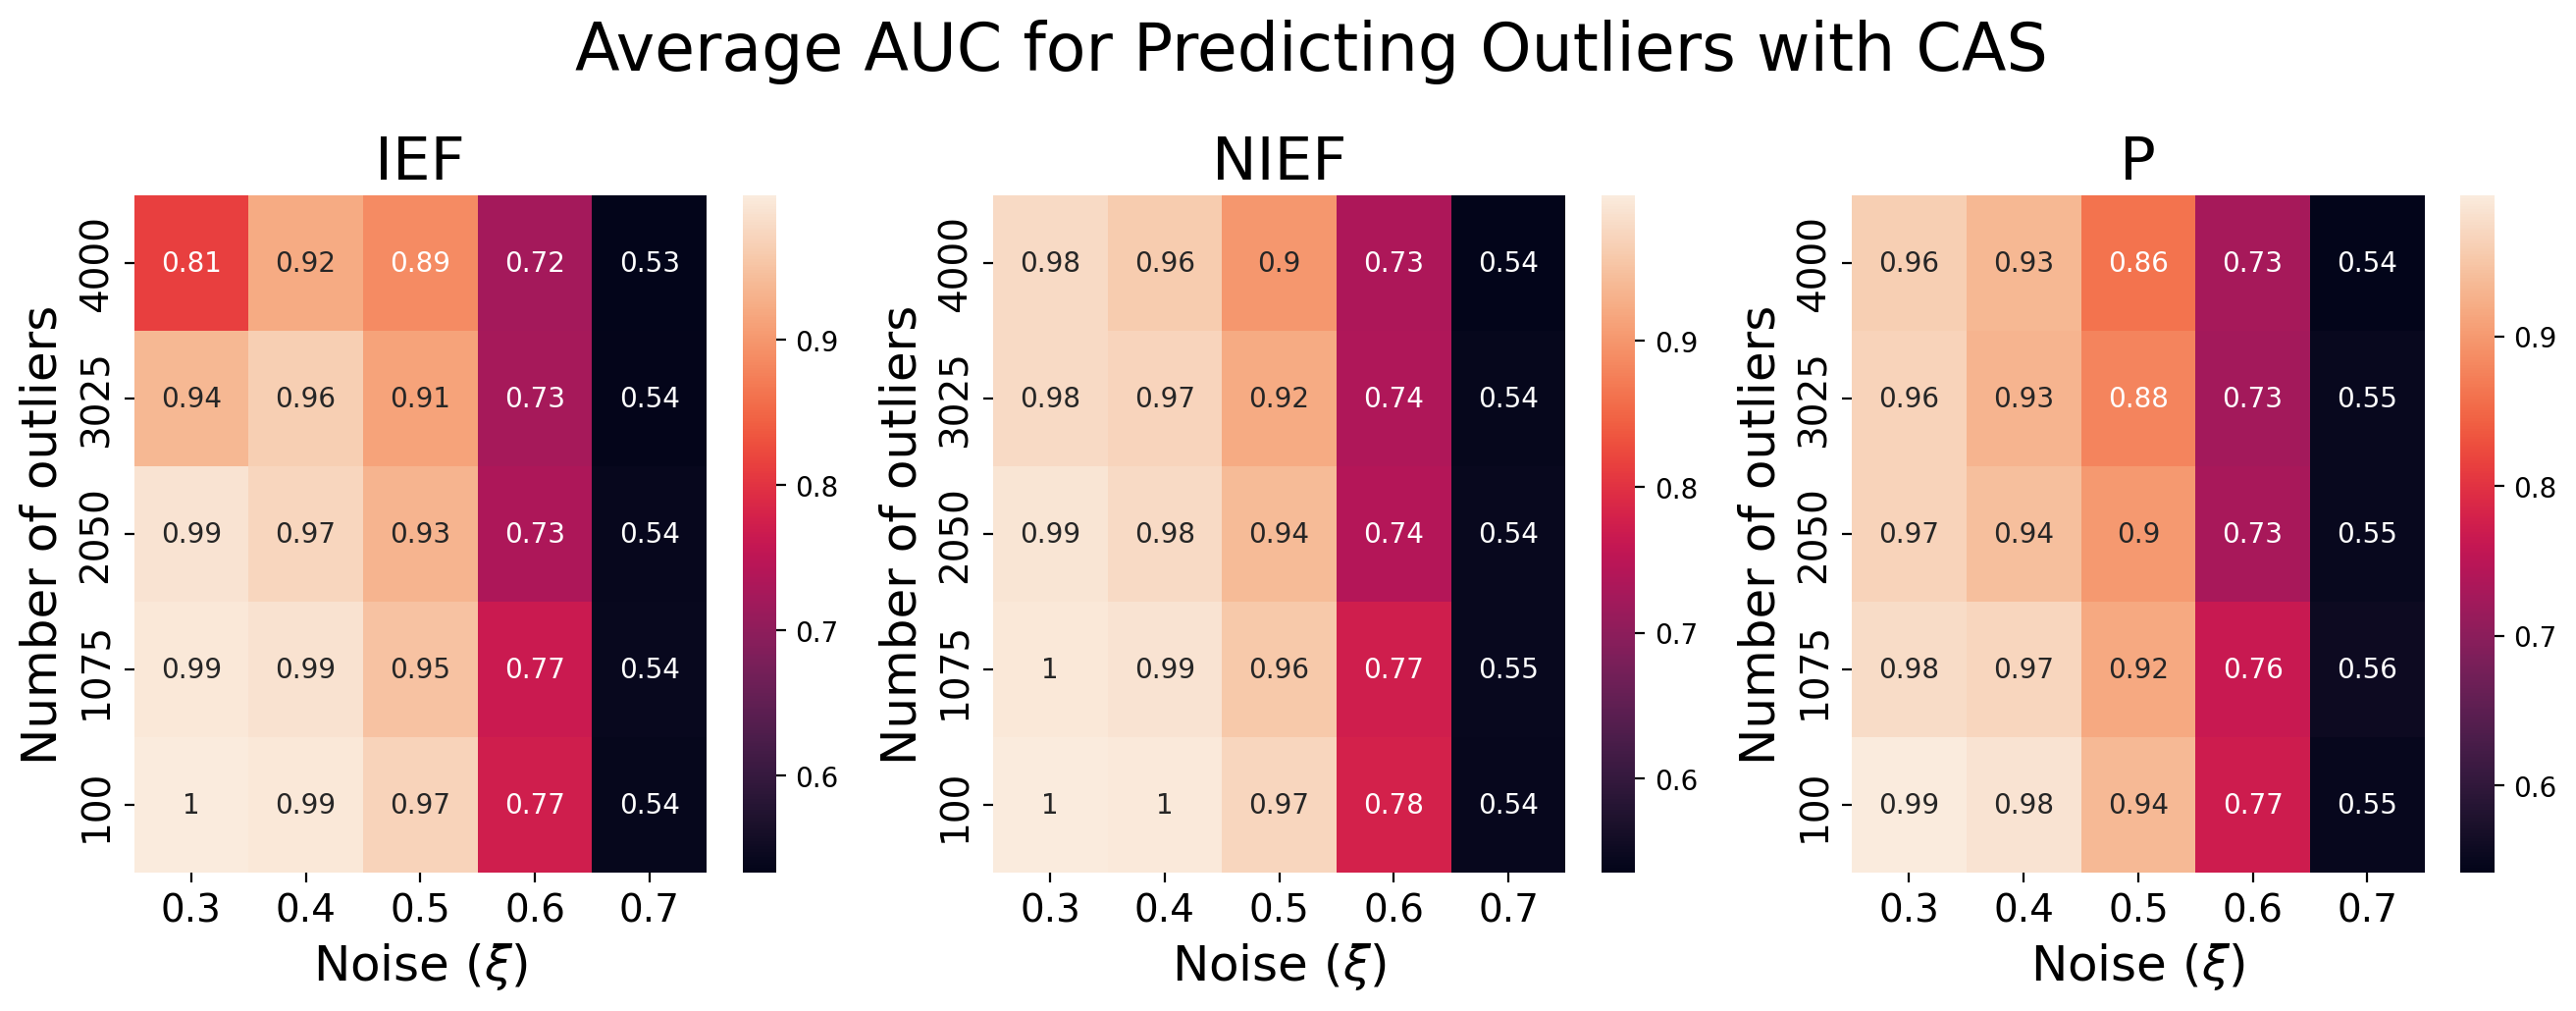

In [94]:
## For one pruning method, make a heatmap of average AUC score
REP = 10
n = 10000
XIS = np.round(np.linspace(0.3, 0.7, 5), 3)
NOUTS = np.linspace(100, 4000, 5, dtype="int64")

ief_aucs = np.empty((len(XIS), len(NOUTS), REP))
nief_aucs = np.empty((len(XIS), len(NOUTS), REP))
p_aucs = np.empty((len(XIS), len(NOUTS), REP))
with tqdm(total=len(XIS)*len(NOUTS)*REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                params = ABCDParams(
                    vcount=n, 
                    gamma=2.5,
                    min_degree=5,
                    max_degree=int(n**.5),
                    beta=1.5,
                    min_community_size=50,
                    max_community_size=int(n**.767),
                    xi=xi,
                    num_outliers=nout,
                )    
                G = ABCDGraph(params)
                G.build()
                adjacency = G.exporter.to_sparse_adjacency_matrix()
                labels = np.array([i for i, com in enumerate(G.communities) for _ in com.vertices])
                is_not_outlier = labels != np.max(labels)
                predict = ECG().fit_predict(adjacency)
                iefs = get_cas(predict, adjacency.indptr, adjacency.indices, adjacency.data, CAS.cas_._ief)
                ief_aucs[i, j, k] = AUC(is_not_outlier, iefs)
                niefs = get_cas(predict, adjacency.indptr, adjacency.indices, adjacency.data, CAS.cas_._nief)
                nief_aucs[i, j, k] = AUC(is_not_outlier, niefs)
                ps = get_cas(predict, adjacency.indptr, adjacency.indices, adjacency.data, CAS.cas_._p)
                p_aucs[i, j, k] = AUC(is_not_outlier, ps)
                pbar.update()

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(top=0.8)  # Make room for suptitle

sns.heatmap(np.flip(np.mean(ief_aucs, axis=2), axis=1).T, xticklabels=XIS, yticklabels=NOUTS[::-1], annot=True, ax=axs[0])
axs[0].set_xlabel(r"Noise ($\xi$)", fontsize=18)
axs[0].set_ylabel("Number of outliers", fontsize=18)
axs[0].tick_params(labelsize=14)
axs[0].set_title("IEF", fontsize=22)

sns.heatmap(np.flip(np.mean(nief_aucs, axis=2), axis=1).T, xticklabels=XIS, yticklabels=NOUTS[::-1], annot=True, ax=axs[1])
axs[1].set_xlabel(r"Noise ($\xi$)", fontsize=18)
axs[1].set_ylabel("Number of outliers", fontsize=18)
axs[1].tick_params(labelsize=14)
axs[1].set_title("NIEF", fontsize=22)

sns.heatmap(np.flip(np.mean(p_aucs, axis=2), axis=1).T, xticklabels=XIS, yticklabels=NOUTS[::-1], annot=True, ax=axs[2])
axs[2].set_xlabel(r"Noise ($\xi$)", fontsize=18)
axs[2].set_ylabel("Number of outliers", fontsize=18)
axs[2].tick_params(labelsize=14)
axs[2].set_title("P", fontsize=22)

plt.suptitle("Average AUC for Predicting Outliers with CAS", fontsize=24, y=0.98)
fig.set_dpi(200)
#fig.savefig("outlier-aucs.png", bbox_inches="tight")

In [95]:
REP = 3
n = 10000
NOUTS = [100, 1000, 4000]
XIS = [.4, .5, .6]
ief_thresholds = np.linspace(0.1, 0.8, 11)
p_thresholds = np.linspace(0.8, 0.999, 11)

ief_f1s = np.empty((len(NOUTS), len(XIS), len(ief_thresholds), REP))
nief_f1s = np.empty((len(NOUTS), len(XIS), len(ief_thresholds), REP))
p_f1s = np.empty((len(NOUTS), len(XIS), len(p_thresholds), REP))

with tqdm(total=len(NOUTS)*len(XIS)*REP) as pbar:
    for i, nout in enumerate(NOUTS):
        for j, xi in enumerate(XIS):
            for k in range(REP):
                params = ABCDParams(
                    vcount=n, 
                    gamma=2.5,
                    min_degree=5,
                    max_degree=int(n**.5),
                    beta=1.5,
                    min_community_size=50,
                    max_community_size=int(n**.767),
                    xi=xi,
                    num_outliers=nout,
                )    
                G = ABCDGraph(params)
                G.build()
                adjacency = G.exporter.to_sparse_adjacency_matrix()
                labels = np.array([i for i, com in enumerate(G.communities) for _ in com.vertices])
                is_outlier = labels == np.max(labels)
                predict = ECG().fit_predict(adjacency)

                for l, thresh in enumerate(ief_thresholds):
                    cas_predict = CAS.CASPostProcesser(score="ief", threshold=thresh).fit_predict(predict, adjacency)
                    ief_f1s[i,j, l, k] = F1(is_outlier, cas_predict == -1)

                for l, thresh in enumerate(ief_thresholds):
                    cas_predict = CAS.CASPostProcesser(score="nief", threshold=thresh).fit_predict(predict, adjacency)
                    nief_f1s[i,j, l, k] = F1(is_outlier, cas_predict == -1)

                for l, thresh in enumerate(p_thresholds):
                    cas_predict = CAS.CASPostProcesser(score="p", threshold=thresh).fit_predict(predict, adjacency)
                    p_f1s[i,j, l, k] = F1(is_outlier, cas_predict == -1)
                  
                pbar.update()


100%|██████████| 27/27 [15:27<00:00, 34.35s/it]


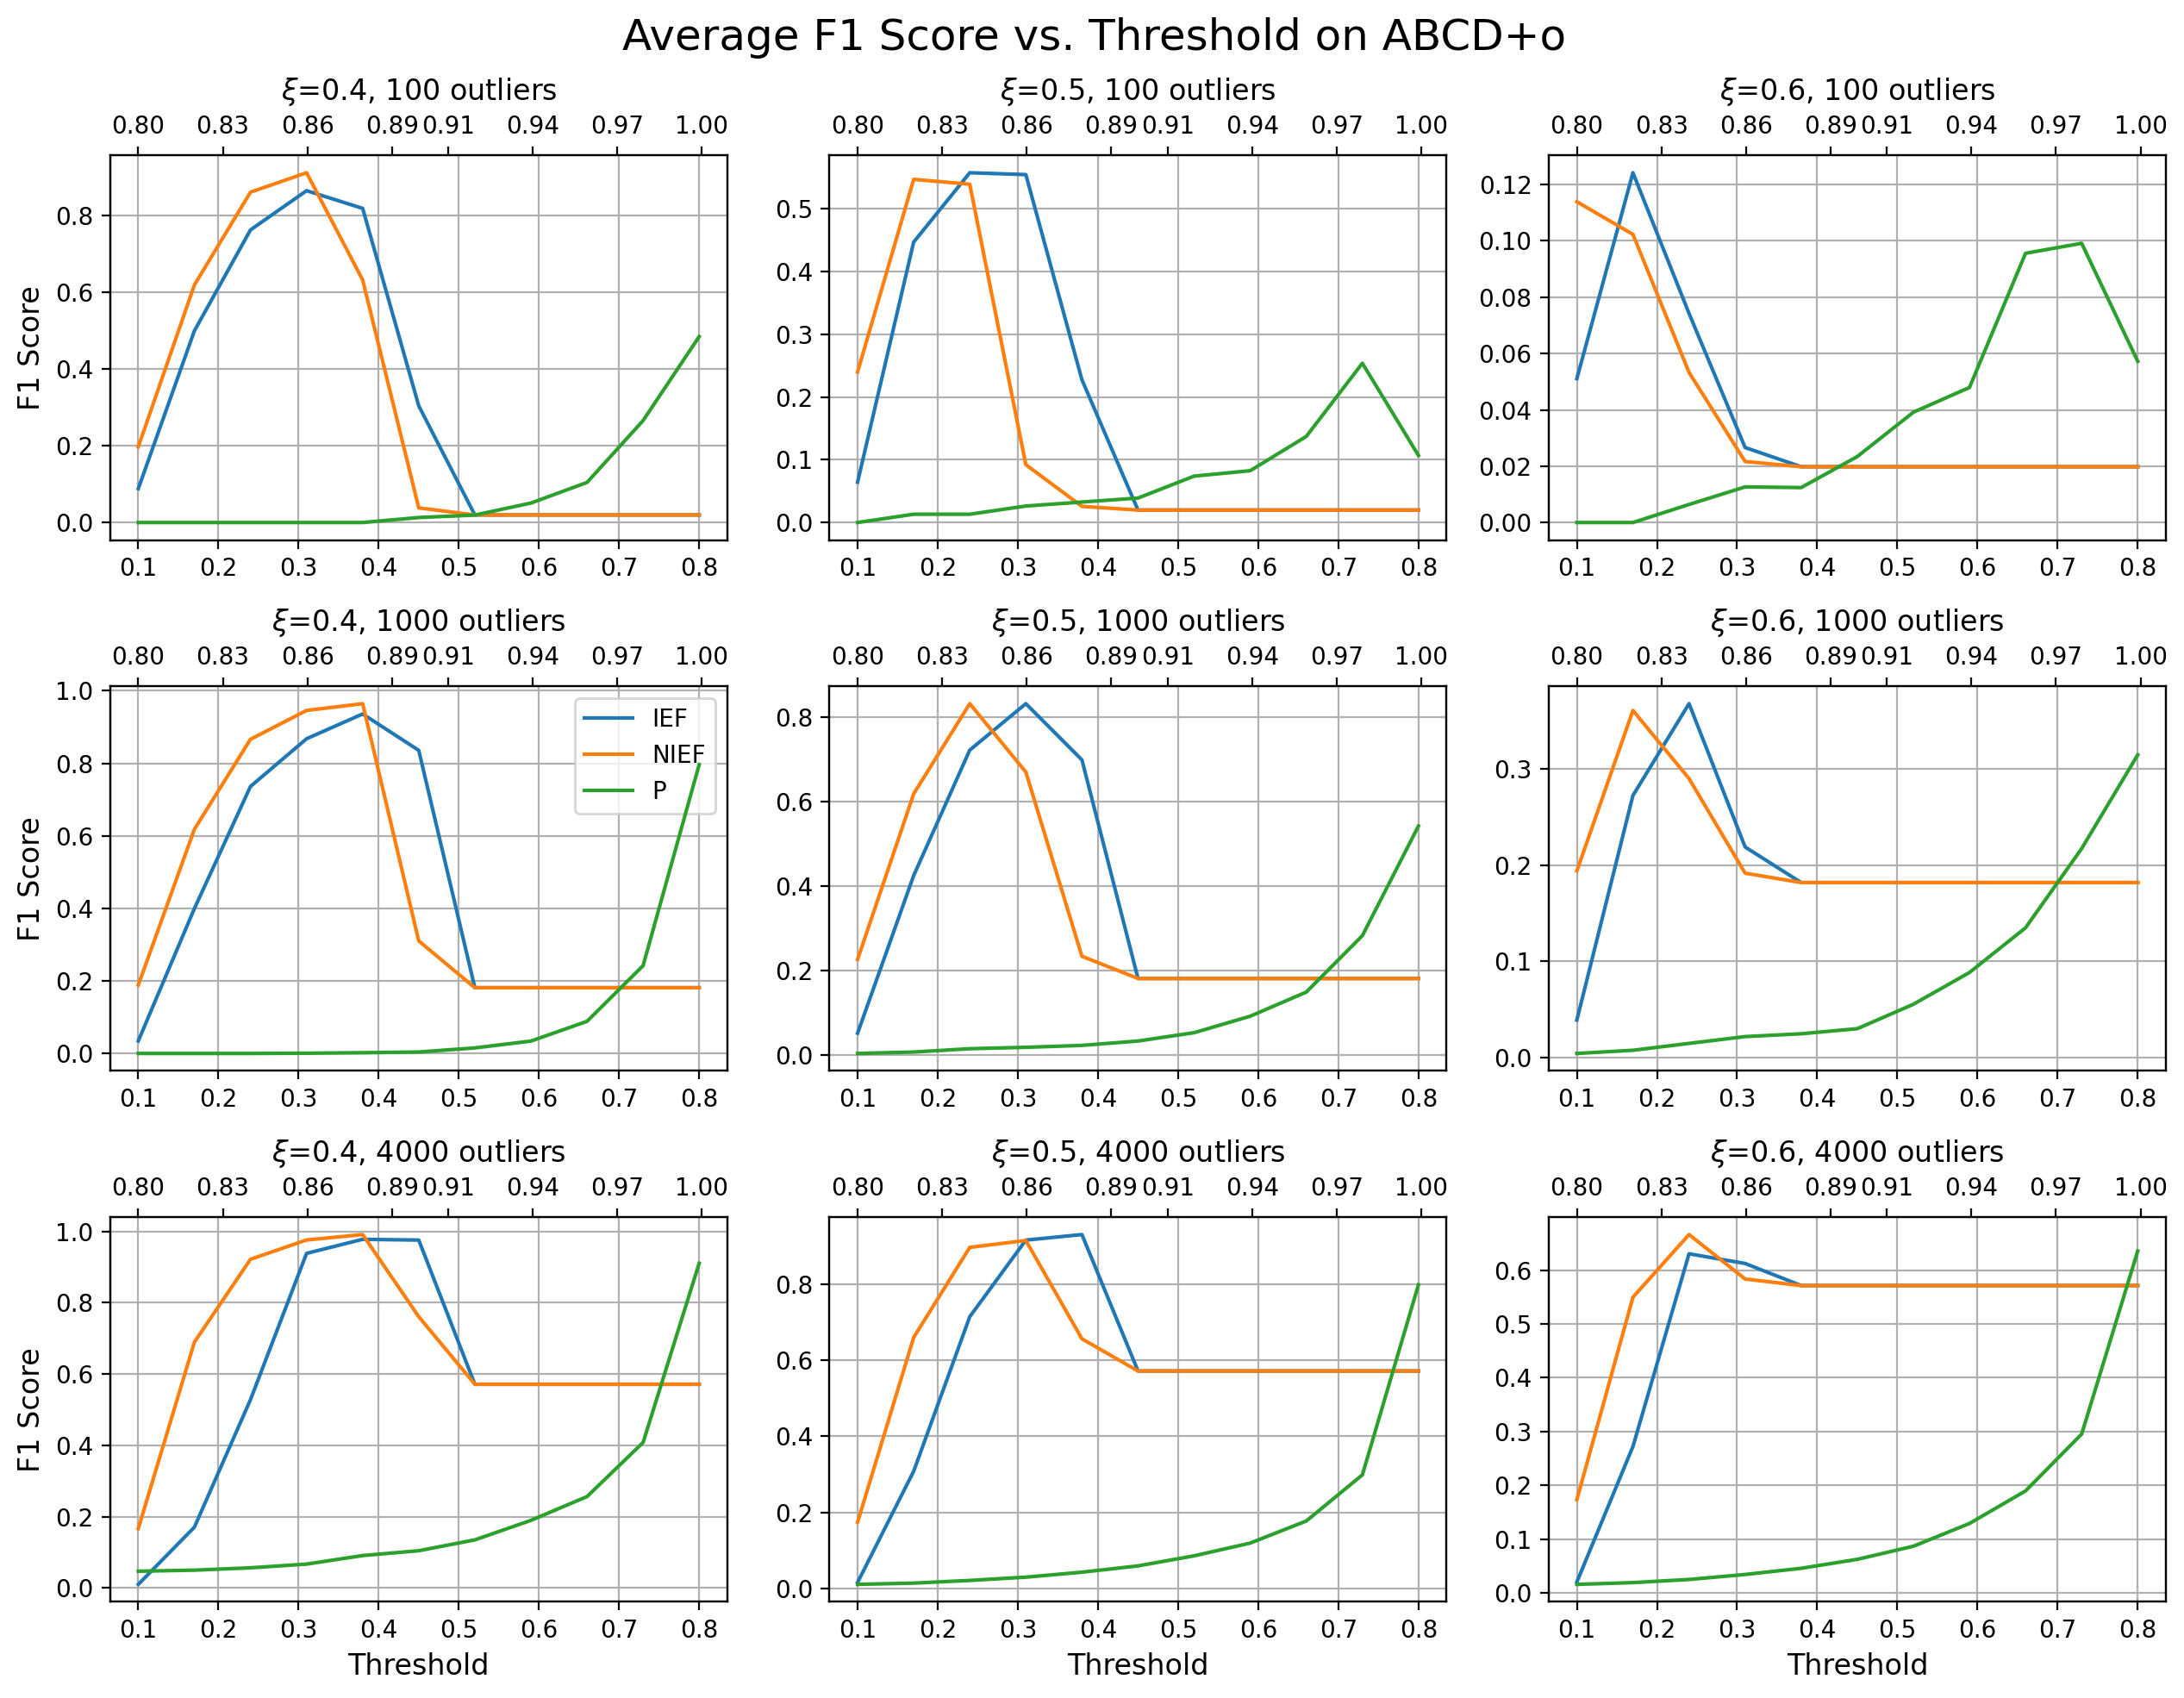

In [98]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']


fig, axs = plt.subplots(3, 3)
for i, nout in enumerate(NOUTS):
    for j, xi in enumerate(XIS):
        lines = []
        twy = axs[i,j].twiny()

        
        lines += axs[i, j].plot(ief_thresholds, np.mean(ief_f1s[i,j,:,:], axis=1), label="IEF", c=colors[0])
        lines += axs[i, j].plot(ief_thresholds, np.mean(nief_f1s[i,j,:,:], axis=1), label="NIEF", c=colors[1])
        lines += twy.plot(p_thresholds, np.mean(p_f1s[i,j,:,:], axis=1), label="P", c=colors[2])
        labels = [l.get_label() for l in lines]

        # Align tick marks, 5 looks good
        n_ticks = 8
        ief_ticks = np.linspace(np.min(ief_thresholds), np.max(ief_thresholds), n_ticks)
        axs[i,j].set_xticks(ief_ticks)
        p_ticks = np.round(np.linspace(np.min(p_thresholds), 1, n_ticks), 2)
        twy.set_xticks(p_ticks)

        axs[i, j].grid()
        axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")

axs[0, 0].set_ylabel("F1 Score", fontsize=12)
axs[1, 0].set_ylabel("F1 Score", fontsize=12)
axs[2, 0].set_ylabel("F1 Score", fontsize=12)
axs[2, 0].set_xlabel("Threshold", fontsize=12)
axs[2, 1].set_xlabel("Threshold", fontsize=12)
axs[2, 2].set_xlabel("Threshold", fontsize=12)
axs[1, 0].legend(lines, labels)
plt.suptitle(f"Average F1 Score vs. Threshold on ABCD+o", fontsize=18)

fig = plt.gcf()
fig.set_size_inches(12.8, 10)
fig.set_dpi(200)
fig.tight_layout()

In [ ]:
# Try 3 threshold vs. xi heatmaps (average each box over several nouts)
# We could try one plots (3 lines) of just F1 vs. threshold (averaged over
# many XIS and NOUTS, since we don't know either of these for real data).
# But maybe that's too complicated to explain, and we would need to make
# uniformity assumptions about the XIS and NOUTS you are likely to see.

In [ ]:
# Try some real data with known outliers (Amazon, DBLP, Youtube, Cora, Football)
# Try on some real data with knwon partitions (eu-email, MNIST/FMNIST, bio-network?)